## Time series generation with narma process

In this version there are 5 features, all cross-correlated with polynomial of order 2 of the parameters


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

time_series_length = 20000
features = 5

# initialization of X and eps (gaussian noise)
X = np.zeros((features, time_series_length))
eps = np.random.normal(0, 0.5, (features, time_series_length))

p = 5
q = 4

# first 5 values of X1 taken from normal distribution
#X[:, 0:p] = np.random.normal(0, 1, p)

# x1, eps1, x1^2, eps1^2, x1*eps1, x2, x2^2, x1*x2, x3, x3^2, x1*x3, x4, x4^2, x1*x4, x5, x5^2, x1*x5
# 5 auto correlation paramteres (x1 and eps1) + 4 cross correlations with the other 4 features
parameters = p + q + p + q + p*q + (p + p + p*p) * (features - 1)

# array of coefficients taken from normal distribution with mean 0 and variance 0.1 of shape = vector.shape
coefficients = np.random.normal(0, 0.05, (features, parameters))


for t in range(max(p, q), time_series_length):

    # polynomial combination of order 2 of X0 and eps0, and X[0:4]
    vector = np.array(np.concatenate([
                        [X[0][t-i] for i in range(1, p+1)], [eps[0][t-i] for i in range(1, q+1)], 
                        [X[0][t-i] **2 for i in range(1, p+1)], [eps[0][t-i] **2 for i in range(1, q+1)],
                        [X[0][t-i] * eps[0][t-j] for i in range(1, p+1) for j in range(1, q+1)],
                        [X[1][t-i] for i in range(1, p+1)], [X[1][t-i] **2 for i in range(1, p+1)],
                        [X[1][t-i] * X[0][t-j] for i in range(1, p+1) for j in range(1, p+1)],
                        [X[2][t-i] for i in range(1, p+1)], [X[2][t-i] **2 for i in range(1, p+1)],
                        [X[2][t-i] * X[0][t-j] for i in range(1, p+1) for j in range(1, p+1)],
                        [X[3][t-i] for i in range(1, p+1)], [X[3][t-i] **2 for i in range(1, p+1)],
                        [X[3][t-i] * X[0][t-j] for i in range(1, p+1) for j in range(1, p+1)],
                        [X[4][t-i] for i in range(1, p+1)], [X[4][t-i] **2 for i in range(1, p+1)],
                        [X[4][t-i] * X[0][t-j] for i in range(1, p+1) for j in range(1, p+1)]
                        ]), dtype=np.float32)

    # create array with 5 rows, and vector as the content of the first row
    polynomial = np.array([vector])


    # polynomial combination of order 2 of X1 and eps1, and X[0:4]
    vector = np.array(np.concatenate([
                        [X[1][t-i] for i in range(1, p+1)], [eps[1][t-i] for i in range(1, q+1)], 
                        [X[1][t-i] **2 for i in range(1, p+1)], [eps[1][t-i] **2 for i in range(1, q+1)],
                        [X[1][t-i] * eps[1][t-j] for i in range(1, p+1) for j in range(1, q+1)],
                        [X[0][t-i] for i in range(1, p+1)], [X[0][t-i] **2 for i in range(1, p+1)],
                        [X[0][t-i] * X[1][t-j] for i in range(1, p+1) for j in range(1, p+1)],
                        [X[2][t-i] for i in range(1, p+1)], [X[2][t-i] **2 for i in range(1, p+1)],
                        [X[2][t-i] * X[1][t-j] for i in range(1, p+1) for j in range(1, p+1)],
                        [X[3][t-i] for i in range(1, p+1)], [X[3][t-i] **2 for i in range(1, p+1)],
                        [X[3][t-i] * X[1][t-j] for i in range(1, p+1) for j in range(1, p+1)],
                        [X[4][t-i] for i in range(1, p+1)], [X[4][t-i] **2 for i in range(1, p+1)],
                        [X[4][t-i] * X[1][t-j] for i in range(1, p+1) for j in range(1, p+1)]
                        ]), dtype=np.float32)

    # add vector to polynomial at the second row
    polynomial = np.append(polynomial, [vector], axis=0)


    # polynomial combination of order 2 of X2 and eps2, and X[0:4]
    vector = np.array(np.concatenate([
                        [X[2][t-i] for i in range(1, p+1)], [eps[2][t-i] for i in range(1, q+1)], 
                        [X[2][t-i] **2 for i in range(1, p+1)], [eps[2][t-i] **2 for i in range(1, q+1)],
                        [X[2][t-i] * eps[2][t-j] for i in range(1, p+1) for j in range(1, q+1)],
                        [X[0][t-i] for i in range(1, p+1)], [X[0][t-i] **2 for i in range(1, p+1)],
                        [X[0][t-i] * X[2][t-j] for i in range(1, p+1) for j in range(1, p+1)],
                        [X[1][t-i] for i in range(1, p+1)], [X[1][t-i] **2 for i in range(1, p+1)],
                        [X[1][t-i] * X[2][t-j] for i in range(1, p+1) for j in range(1, p+1)],
                        [X[3][t-i] for i in range(1, p+1)], [X[3][t-i] **2 for i in range(1, p+1)],
                        [X[3][t-i] * X[2][t-j] for i in range(1, p+1) for j in range(1, p+1)],
                        [X[4][t-i] for i in range(1, p+1)], [X[4][t-i] **2 for i in range(1, p+1)],
                        [X[4][t-i] * X[2][t-j] for i in range(1, p+1) for j in range(1, p+1)]
                        ]), dtype=np.float32)

    # add vector to polynomial at the second row
    polynomial = np.append(polynomial, [vector], axis=0)


    # polynomial combination of order 2 of X3 and eps3, and X[0:4]
    vector = np.array(np.concatenate([
                        [X[3][t-i] for i in range(1, p+1)], [eps[3][t-i] for i in range(1, q+1)], 
                        [X[3][t-i] **2 for i in range(1, p+1)], [eps[3][t-i] **2 for i in range(1, q+1)],
                        [X[3][t-i] * eps[3][t-j] for i in range(1, p+1) for j in range(1, q+1)],
                        [X[0][t-i] for i in range(1, p+1)], [X[0][t-i] **2 for i in range(1, p+1)],
                        [X[0][t-i] * X[3][t-j] for i in range(1, p+1) for j in range(1, p+1)],
                        [X[1][t-i] for i in range(1, p+1)], [X[1][t-i] **2 for i in range(1, p+1)],
                        [X[1][t-i] * X[3][t-j] for i in range(1, p+1) for j in range(1, p+1)],
                        [X[2][t-i] for i in range(1, p+1)], [X[2][t-i] **2 for i in range(1, p+1)],
                        [X[2][t-i] * X[3][t-j] for i in range(1, p+1) for j in range(1, p+1)],
                        [X[4][t-i] for i in range(1, p+1)], [X[4][t-i] **2 for i in range(1, p+1)],
                        [X[4][t-i] * X[3][t-j] for i in range(1, p+1) for j in range(1, p+1)]
                        ]), dtype=np.float32)

    # add vector to polynomial at the second row
    polynomial = np.append(polynomial, [vector], axis=0)


    # polynomial combination of order 2 of X4 and eps4, and X[0:4]
    vector = np.array(np.concatenate([
                        [X[4][t-i] for i in range(1, p+1)], [eps[4][t-i] for i in range(1, q+1)], 
                        [X[4][t-i] **2 for i in range(1, p+1)], [eps[4][t-i] **2 for i in range(1, q+1)],
                        [X[4][t-i] * eps[4][t-j] for i in range(1, p+1) for j in range(1, q+1)],
                        [X[0][t-i] for i in range(1, p+1)], [X[0][t-i] **2 for i in range(1, p+1)],
                        [X[0][t-i] * X[4][t-j] for i in range(1, p+1) for j in range(1, p+1)],
                        [X[1][t-i] for i in range(1, p+1)], [X[1][t-i] **2 for i in range(1, p+1)],
                        [X[1][t-i] * X[4][t-j] for i in range(1, p+1) for j in range(1, p+1)],
                        [X[2][t-i] for i in range(1, p+1)], [X[2][t-i] **2 for i in range(1, p+1)],
                        [X[2][t-i] * X[4][t-j] for i in range(1, p+1) for j in range(1, p+1)],
                        [X[3][t-i] for i in range(1, p+1)], [X[3][t-i] **2 for i in range(1, p+1)],
                        [X[3][t-i] * X[4][t-j] for i in range(1, p+1) for j in range(1, p+1)]
                        ]), dtype=np.float32)

    # add vector to polynomial at the second row
    polynomial = np.append(polynomial, [vector], axis=0)

    for f in range(features):
        # compute dot product between coefficients and polynomial, for every f
        X[f][t] = np.dot(coefficients[f], polynomial[f]) + eps[f][t]



print("polynomial shape = ", polynomial.shape)
print("coefficient shape = ", coefficients.shape)



# plot X time series, for every f
for f in range(features):
    plt.plot(X[f])
    plt.show()




## NARMA data generator with 6 features and concept drift in binary labeling

In the second version, there are 6 features, each of them cross-correlated with other 2 features.
As a result, x1, x2, x3 are cross-correlated, and x4, x5, x6 are cross-correlated.
The features are composed by a polynomial comnination of order 2 of the features and the noise.
The process is a non linear ARMA(p, q)

In [60]:
import numpy as np
import matplotlib.pyplot as plt

time_series_length = 20000
features = 6

# initialization of X and eps (gaussian noise)
X = np.zeros((features, time_series_length))
eps = np.random.normal(0, 0.5, (features, time_series_length))

p = 5
q = 8

# first p values of X1 taken from normal distribution
#X[:, 0:q] = np.random.normal(0, 5, (features, q))

print(f"creation of X time series representing a NARMA({p},{q}) process of length {time_series_length}...")

# x1, eps1, x1^2, eps1^2, x1*eps1, x2, x2^2, x1*x2, x3, x3^2, x1*x3
# x4, eps4, x4^2, eps4^2, x4*eps4, x5, x5^2, x4*x5, x6, x6^2, x4*x6
# 5 auto correlation paramteres (x1 and eps1) + 2 cross correlations with other 2 features
parameters = p + q + p + q + p*q + (p + p + p*p) * 2

creation of X time series representing a NARMA(5,8) process of length 20000...


In [61]:
def compute_polynomials(X, t):
	polynomial = np.zeros((features, parameters), dtype=np.float32)
	
	# polynomial combination of order 2 of X0 and eps0, and X[0:4]
	vector = np.array(np.concatenate([
						[X[0][t-i] for i in range(1, p+1)], [eps[0][t-i] for i in range(1, q+1)], 
						[X[0][t-i] **2 for i in range(1, p+1)], [eps[0][t-i] **2 for i in range(1, q+1)],
						[X[0][t-i] * eps[0][t-j] for i in range(1, p+1) for j in range(1, q+1)],
						[X[1][t-i] for i in range(1, p+1)], [X[1][t-i] **2 for i in range(1, p+1)],
						[X[1][t-i] * X[0][t-j] for i in range(1, p+1) for j in range(1, p+1)],
						[X[2][t-i] for i in range(1, p+1)], [X[2][t-i] **2 for i in range(1, p+1)],
						[X[2][t-i] * X[0][t-j] for i in range(1, p+1) for j in range(1, p+1)]
						]), dtype=np.float32)

	# create array with 5 rows, and vector as the content of the first row
	polynomial[0] = np.array([vector])

	# polynomial combination of order 2 of X1 and eps1, and X[0:4]
	vector = np.array(np.concatenate([
						[X[1][t-i] for i in range(1, p+1)], [eps[1][t-i] for i in range(1, q+1)], 
						[X[1][t-i] **2 for i in range(1, p+1)], [eps[1][t-i] **2 for i in range(1, q+1)],
						[X[1][t-i] * eps[1][t-j] for i in range(1, p+1) for j in range(1, q+1)],
						[X[0][t-i] for i in range(1, p+1)], [X[0][t-i] **2 for i in range(1, p+1)],
						[X[0][t-i] * X[1][t-j] for i in range(1, p+1) for j in range(1, p+1)],
						[X[2][t-i] for i in range(1, p+1)], [X[2][t-i] **2 for i in range(1, p+1)],
						[X[2][t-i] * X[1][t-j] for i in range(1, p+1) for j in range(1, p+1)]
						]), dtype=np.float32)

	# add vector to polynomial
	#polynomial = np.append(polynomial, [vector], axis=0)
	polynomial[1] = np.array([vector])


	# polynomial combination of order 2 of X2 and eps2, and X[0:4]
	vector = np.array(np.concatenate([
						[X[2][t-i] for i in range(1, p+1)], [eps[2][t-i] for i in range(1, q+1)], 
						[X[2][t-i] **2 for i in range(1, p+1)], [eps[2][t-i] **2 for i in range(1, q+1)],
						[X[2][t-i] * eps[2][t-j] for i in range(1, p+1) for j in range(1, q+1)],
						[X[0][t-i] for i in range(1, p+1)], [X[0][t-i] **2 for i in range(1, p+1)],
						[X[0][t-i] * X[2][t-j] for i in range(1, p+1) for j in range(1, p+1)],
						[X[1][t-i] for i in range(1, p+1)], [X[1][t-i] **2 for i in range(1, p+1)],
						[X[1][t-i] * X[2][t-j] for i in range(1, p+1) for j in range(1, p+1)]
						]), dtype=np.float32)

	# add vector to polynomial
	#polynomial = np.append(polynomial, [vector], axis=0)
	polynomial[2] = np.array([vector])


	# polynomial combination of order 2 of X3 and eps3, and X4 and X5
	vector = np.array(np.concatenate([
						[X[3][t-i] for i in range(1, p+1)], [eps[3][t-i] for i in range(1, q+1)], 
						[X[3][t-i] **2 for i in range(1, p+1)], [eps[3][t-i] **2 for i in range(1, q+1)],
						[X[3][t-i] * eps[3][t-j] for i in range(1, p+1) for j in range(1, q+1)],
						[X[4][t-i] for i in range(1, p+1)], [X[4][t-i] **2 for i in range(1, p+1)],
						[X[4][t-i] * X[3][t-j] for i in range(1, p+1) for j in range(1, p+1)],
						[X[5][t-i] for i in range(1, p+1)], [X[5][t-i] **2 for i in range(1, p+1)],
						[X[5][t-i] * X[3][t-j] for i in range(1, p+1) for j in range(1, p+1)]
						]), dtype=np.float32)

	# add vector to polynomial
	#polynomial = np.append(polynomial, [vector], axis=0)
	polynomial[3] = np.array([vector])


	# polynomial combination of order 2 of X4 and eps4, and X3, X5
	vector = np.array(np.concatenate([
						[X[4][t-i] for i in range(1, p+1)], [eps[4][t-i] for i in range(1, q+1)], 
						[X[4][t-i] **2 for i in range(1, p+1)], [eps[4][t-i] **2 for i in range(1, q+1)],
						[X[4][t-i] * eps[4][t-j] for i in range(1, p+1) for j in range(1, q+1)],
						[X[3][t-i] for i in range(1, p+1)], [X[3][t-i] **2 for i in range(1, p+1)],
						[X[3][t-i] * X[4][t-j] for i in range(1, p+1) for j in range(1, p+1)],
						[X[5][t-i] for i in range(1, p+1)], [X[5][t-i] **2 for i in range(1, p+1)],
						[X[5][t-i] * X[4][t-j] for i in range(1, p+1) for j in range(1, p+1)]
						]), dtype=np.float32)

	# add vector to polynomial
	#polynomial = np.append(polynomial, [vector], axis=0)
	polynomial[4] = np.array([vector])

	# polynomial combination of order 2 of X4 and eps4, and X3, X5
	vector = np.array(np.concatenate([
						[X[5][t-i] for i in range(1, p+1)], [eps[5][t-i] for i in range(1, q+1)], 
						[X[5][t-i] **2 for i in range(1, p+1)], [eps[5][t-i] **2 for i in range(1, q+1)],
						[X[5][t-i] * eps[5][t-j] for i in range(1, p+1) for j in range(1, q+1)],
						[X[3][t-i] for i in range(1, p+1)], [X[3][t-i] **2 for i in range(1, p+1)],
						[X[3][t-i] * X[5][t-j] for i in range(1, p+1) for j in range(1, p+1)],
						[X[4][t-i] for i in range(1, p+1)], [X[4][t-i] **2 for i in range(1, p+1)],
						[X[4][t-i] * X[5][t-j] for i in range(1, p+1) for j in range(1, p+1)]
						]), dtype=np.float32)

	# add vector to polynomial
	#polynomial = np.append(polynomial, [vector], axis=0)
	polynomial[5] = np.array([vector])

	return polynomial
	

Computation of a linear combination of the coefficients and the polynomial function of the NARMA process

In [62]:

# array of coefficients taken from normal distribution with mean 0 and variance 0.05 of shape = vector.shape
coefficients = np.random.normal(0, 0.04, (features, parameters))
print("coefficient shape = ", coefficients.shape)

# for each time stamp t in the time series
for t in range(max(p, q), time_series_length):
    # compute polynomial combination of order 2 for all features and time steps
    polynomial = compute_polynomials(X, t)
    
    for f in range(features):
        # compute dot product between coefficients and polynomial, for every f
        X[f][t] = np.dot(coefficients[f], polynomial[f]) + eps[f][t]

print("dataset shape = ", X.shape)


coefficient shape =  (6, 136)
dataset shape =  (6, 20000)


Plot the 6 features

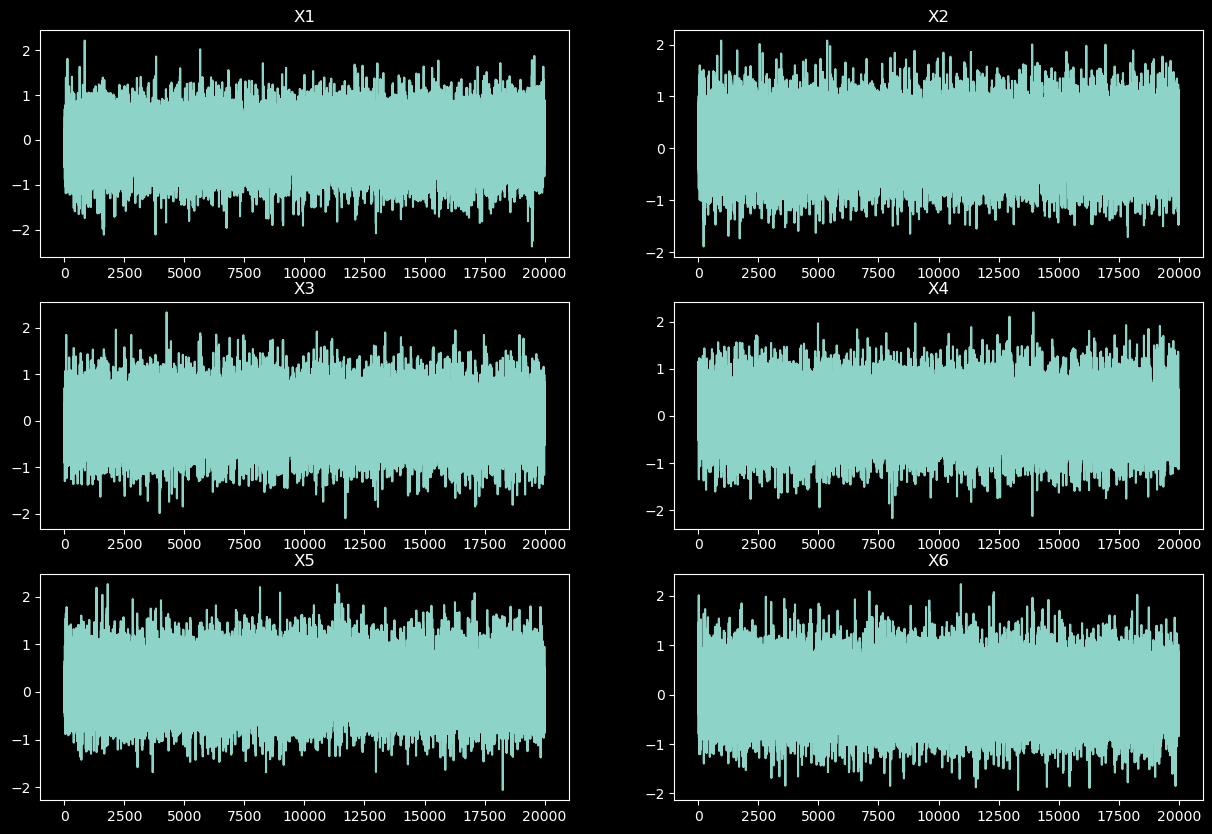

In [63]:

# plot X time series, for every feature, in a plot with 6 subplots, in a grid of 3x2
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
for f in range(features):
    axs[f//2, f%2].plot(X[f])
    axs[f//2, f%2].set_title('X' + str(f+1))
plt.show()


Concept drift smooth transition of size drift_width and at position drift_position, using a sigmoid function

In [64]:
drifting_probabilities = np.random.uniform(0, 1, size=time_series_length)
drift_width = time_series_length / 50.0 # drift width is 2.5% of the time series length
drift_position = time_series_length / 2.0 # drift starts at the middle of the time series

# create sigmoid function used as probability of drift in time
sigmoid = [(1 / (1 + np.exp(- 4 * (t - drift_position) / drift_width))) for t in range(time_series_length)]

print("drifting position = ", drift_position, " with width = ", drift_width)

drifting position =  10000.0  with width =  400.0


Computation of 2 labels and introduction of concept drift

In [65]:
# create binary labels named Y of length time_series_length
Y = np.zeros(time_series_length, dtype=np.int32)

# for every time t, apply label 1 or 2 to the time series according to the sigmoid function (drift or not)
for t in range(max(p, q), time_series_length):

	if (drifting_probabilities[t] > sigmoid[t]):
		# apply label 1
		value = np.sum([(np.sin(2 * np.pi * X[0][t - i]) + np.sin(2 * np.pi * X[1][t - i]) + np.sin(2 * np.pi * X[3][t - i])) for i in range(0, 5)])
		value = value / 4.0 + np.sum([np.exp(Y[t - i]) for i in range(1, 3)]) / 10.0

		# if value is negative, set it to 0, else to 1
		Y[t] = 1 if value > 0 else 0
		#Y[t] = 1 if X[1, t] > 0 else 0
	else:
		# apply label 2
		value = np.sum([(np.sin(3 * np.pi * X[2][t - i]) + np.sin(3 * np.pi * X[4][t - i]) + np.sin(3 * np.pi * X[5][t - i])) for i in range(0, 3)])
		value = value / 3.0 - np.sum([np.exp(Y[t - i]) for i in range(1, 3)]) / 10.0

		# if value is negative, set it to 0, else to 1
		Y[t] = 1 if value > 0 else 0
		#Y[t] = 1 if X[5, t] > 0 else 0

print("X shape = ", X.shape)
print("Y shape = ", Y.shape)



X shape =  (6, 20000)
Y shape =  (20000,)


plot label function (0s and 1s) and the sigmoid function for drift computation

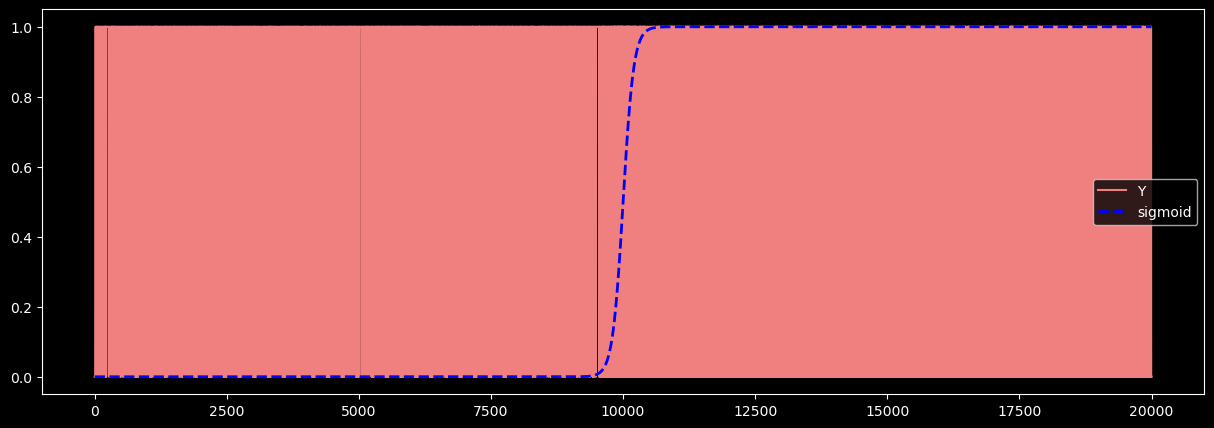

In [66]:

#plot Y time series and sigmoid in the same plot with different colors
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(Y, color='lightblue', label='Y)
ax.plot(sigmoid, color='blue', linestyle='--', linewidth=2)
# add legend to the plot
ax.legend(['Y', 'sigmoid'])
plt.show()


create numpy array with X as feature vectors and Y as binary labels

In [67]:
# create dataset using X as feature vectors and Y as binary labels
dataset = np.concatenate((X, [Y]), axis=0)
print("dataset shape = ", dataset.shape)


dataset shape =  (7, 20000)


Save computed time series into a csv file

In [68]:
# save dataset time series in a csv file, where each column is a time series and the last column is the label
np.savetxt("dataset_drift_labels.csv", dataset.T, delimiter=",")

### Second dataset where concept drift is in the choice of the NARMA process polynomials

In [69]:
# initialization of X and eps (gaussian noise)
X = np.zeros((features, time_series_length))
eps = np.random.normal(0, 0.5, (features, time_series_length))


Concept drift is created by changing the polynomials factors. The new generated process is different in terms of cross correlation between variables

In [70]:
def compute_polynomials_2(X, t):
	polynomial = np.zeros((features, parameters), dtype=np.float32)
	
	# polynomial combination of order 2 of X0 and eps0, and X[0:4]
	vector = np.array(np.concatenate([
						[X[0][t-i] for i in range(1, p+1)], [eps[0][t-i] for i in range(1, q+1)], 
						[X[0][t-i] **2 for i in range(1, p+1)],	[eps[0][t-i] **2 for i in range(1, q+1)],
						[X[0][t-i] * eps[0][t-j] for i in range(1, p+1) for j in range(1, q+1)],
						[X[4][t-i] for i in range(1, p+1)], [X[4][t-i] **2 for i in range(1, p+1)],
						[X[4][t-i] * X[0][t-j] for i in range(1, p+1) for j in range(1, p+1)],
						[X[5][t-i] for i in range(1, p+1)], [X[5][t-i] **2 for i in range(1, p+1)],
						[X[5][t-i] * X[0][t-j] for i in range(1, p+1) for j in range(1, p+1)]
						]), dtype=np.float32)

	# create array with 5 rows, and vector as the content of the first row
	polynomial[0] = np.array([vector])

	# polynomial combination of order 2 of X1 and eps1, and X[0:4]
	vector = np.array(np.concatenate([
						[X[1][t-i] for i in range(1, p+1)], [eps[1][t-i] for i in range(1, q+1)], 
						[X[1][t-i] **2 for i in range(1, p+1)], [eps[1][t-i] **2 for i in range(1, q+1)],
						[X[1][t-i] * eps[1][t-j] for i in range(1, p+1) for j in range(1, q+1)],
						[X[3][t-i] for i in range(1, p+1)], [X[3][t-i] **2 for i in range(1, p+1)],
						[X[3][t-i] * X[1][t-j] for i in range(1, p+1) for j in range(1, p+1)],
						[X[2][t-i] for i in range(1, p+1)], [X[2][t-i] **2 for i in range(1, p+1)],
						[X[2][t-i] * X[1][t-j] for i in range(1, p+1) for j in range(1, p+1)]
						]), dtype=np.float32)

	# add vector to polynomial
	#polynomial = np.append(polynomial, [vector], axis=0)
	polynomial[1] = np.array([vector])


	# polynomial combination of order 2 of X2 and eps2, and X[0:4]
	vector = np.array(np.concatenate([
						[X[2][t-i] for i in range(1, p+1)], [eps[2][t-i] for i in range(1, q+1)], 
						[X[2][t-i] **2 for i in range(1, p+1)],
						[eps[2][t-i] **2 for i in range(1, q+1)],
						[X[2][t-i] * eps[2][t-j] for i in range(1, p+1) for j in range(1, q+1)],
						[X[3][t-i] for i in range(1, p+1)], [X[3][t-i] **2 for i in range(1, p+1)],
						[X[3][t-i] * X[2][t-j] for i in range(1, p+1) for j in range(1, p+1)],
						[X[1][t-i] for i in range(1, p+1)], [X[1][t-i] **2 for i in range(1, p+1)],
						[X[1][t-i] * X[2][t-j] for i in range(1, p+1) for j in range(1, p+1)]
						]), dtype=np.float32)

	# add vector to polynomial
	#polynomial = np.append(polynomial, [vector], axis=0)
	polynomial[2] = np.array([vector])


	# polynomial combination of order 2 of X3 and eps3, and X4 and X5
	vector = np.array(np.concatenate([
						[X[3][t-i] for i in range(1, p+1)], [eps[3][t-i] for i in range(1, q+1)], 
						[X[3][t-i] **2 for i in range(1, p+1)],
						[eps[3][t-i] **2 for i in range(1, q+1)],
						[X[3][t-i] * eps[3][t-j] for i in range(1, p+1) for j in range(1, q+1)],
						[X[1][t-i] for i in range(1, p+1)], [X[1][t-i] **2 for i in range(1, p+1)],
						[X[1][t-i] * X[3][t-j] for i in range(1, p+1) for j in range(1, p+1)],
						[X[2][t-i] for i in range(1, p+1)], [X[2][t-i] **2 for i in range(1, p+1)],
						[X[2][t-i] * X[3][t-j] for i in range(1, p+1) for j in range(1, p+1)]
						]), dtype=np.float32)

	# add vector to polynomial
	#polynomial = np.append(polynomial, [vector], axis=0)
	polynomial[3] = np.array([vector])


	# polynomial combination of order 2 of X4 and eps4, and X3, X5
	vector = np.array(np.concatenate([
						[X[4][t-i] for i in range(1, p+1)], [eps[4][t-i] for i in range(1, q+1)], 
						[X[4][t-i] **2 for i in range(1, p+1)],
						[eps[4][t-i] **2 for i in range(1, q+1)],
						[X[4][t-i] * eps[4][t-j] for i in range(1, p+1) for j in range(1, q+1)],
						[X[5][t-i] for i in range(1, p+1)], [X[5][t-i] **2 for i in range(1, p+1)],
						[X[5][t-i] * X[4][t-j] for i in range(1, p+1) for j in range(1, p+1)],
						[X[0][t-i] for i in range(1, p+1)], [X[0][t-i] **2 for i in range(1, p+1)],
						[X[0][t-i] * X[4][t-j] for i in range(1, p+1) for j in range(1, p+1)]
						]), dtype=np.float32)

	# add vector to polynomial
	#polynomial = np.append(polynomial, [vector], axis=0)
	polynomial[4] = np.array([vector])

	# polynomial combination of order 2 of X4 and eps4, and X3, X5
	vector = np.array(np.concatenate([
						[X[5][t-i] for i in range(1, p+1)], [eps[5][t-i] for i in range(1, q+1)], 
						[X[5][t-i] **2 for i in range(1, p+1)],
						[eps[5][t-i] **2 for i in range(1, q+1)],
						[X[5][t-i] * eps[5][t-j] for i in range(1, p+1) for j in range(1, q+1)],
						[X[0][t-i] for i in range(1, p+1)], [X[0][t-i] **2 for i in range(1, p+1)],
						[X[0][t-i] * X[5][t-j] for i in range(1, p+1) for j in range(1, p+1)],
						[X[4][t-i] for i in range(1, p+1)], [X[4][t-i] **2 for i in range(1, p+1)],
						[X[4][t-i] * X[5][t-j] for i in range(1, p+1) for j in range(1, p+1)]
						]), dtype=np.float32)

	# add vector to polynomial
	#polynomial = np.append(polynomial, [vector], axis=0)
	polynomial[5] = np.array([vector])

	return polynomial
	

In [71]:
X = np.zeros((features, time_series_length))
eps = np.random.normal(0, 0.5, (features, time_series_length))

# array of coefficients taken from normal distribution with mean 0 and variance 0.05 of shape = vector.shape

coefficients = np.random.beta(a = 2, b = 5, size = (features, parameters)) * np.random.choice([-1, 1], size = (features, parameters)) / 10
print("coefficient shape = ", coefficients.shape)


# for each time stamp t in the time series
for t in range(max(p, q), time_series_length):

    # compute polynomial combination of order 2 for all features and time steps
    polynomials_1 = compute_polynomials(X, t)
    polynomials_2 = compute_polynomials_2(X, t)

    for f in range(features):
        # assign coefficients based on the probability of concept drift at time t
        if (drifting_probabilities[t] > sigmoid[t]):
            # compute dot product between coefficients and polynomial, for every f
            X[f][t] = np.dot(coefficients[f], polynomials_1[f]) + eps[f][t]
        else:
            # compute dot product between coefficients and polynomial, for every f
            X[f][t] = np.dot(coefficients[f], polynomials_2[f]) + eps[f][t]



coefficient shape =  (6, 136)


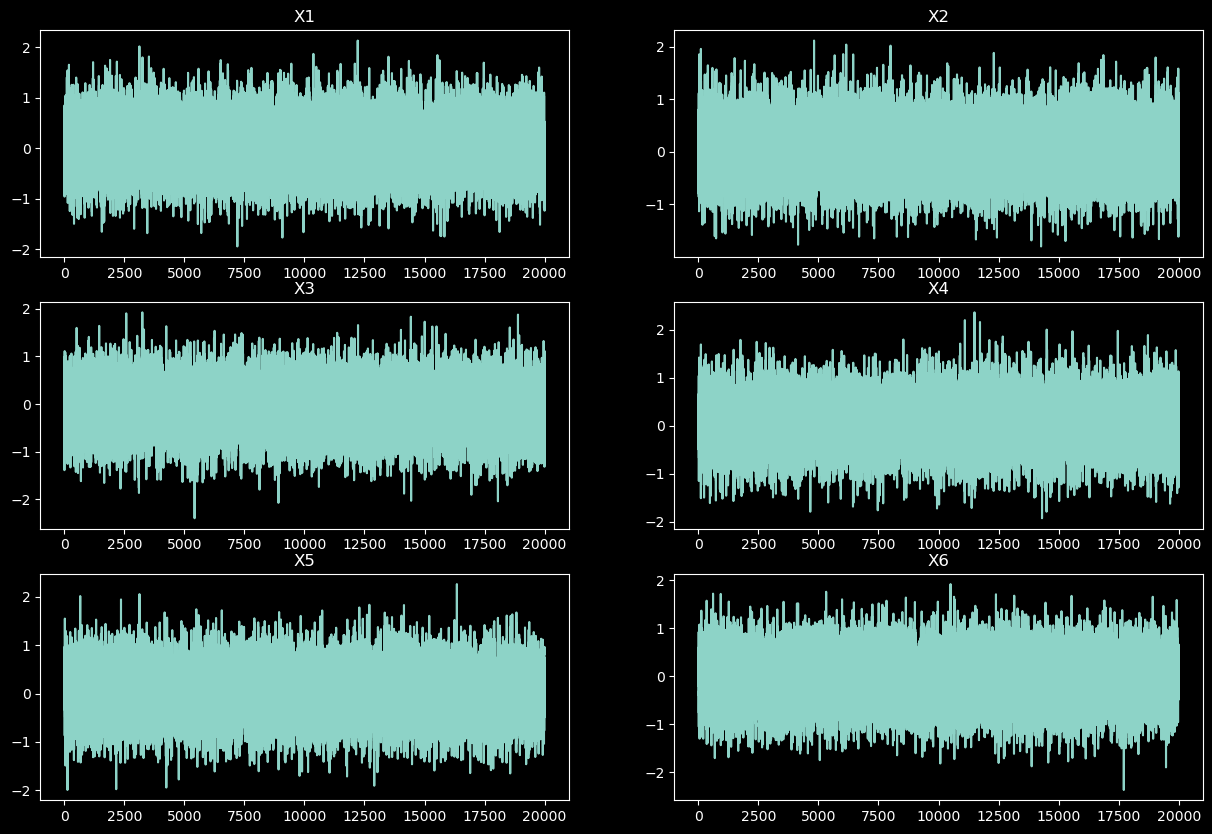

In [72]:

# plot X time series, for every feature, in a plot with 6 subplots, in a grid of 3x2
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
for f in range(features):
    axs[f//2, f%2].plot(X[f])
    axs[f//2, f%2].set_title('X' + str(f+1))
plt.show()


Binary labeling function is unique and constant over time

In [73]:
# create binary labels named Y of length time_series_length
Y = np.zeros(time_series_length, dtype=np.int32)

# for every time t, apply label 1 or 2 to the time series according to the sigmoid function (drift or not)
for t in range(max(p, q), time_series_length):
	# apply binary label function
	value = np.sum([(np.sin(2 * np.pi * X[0][t - i]) + np.sin(2 * np.pi * X[1][t - i]) + np.sin(2 * np.pi * X[3][t - i])) for i in range(0, 5)])
	#value = value / 4.0 + np.sum([np.exp(Y[t - i]) for i in range(1, 3)]) / 10.0
	#value = np.sum([np.sin(np.pi * X[0][t - i] * X[1][t - i]) for i in range(0, 5)])

	# if value is negative, set it to 0, else to 1
	Y[t] = 1 if value > 0 else 0

print("X shape = ", X.shape)
print("Y shape = ", Y.shape)



X shape =  (6, 20000)
Y shape =  (20000,)


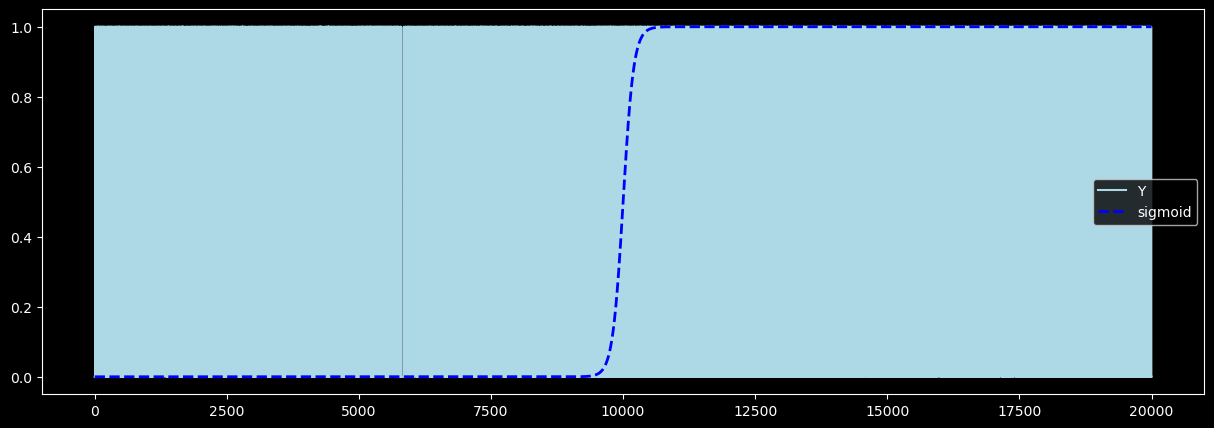

In [74]:

#plot Y time series and sigmoid in the same plot with different colors
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(Y, color='lightblue', label='Y')
ax.plot(sigmoid, color='blue', linestyle='--', linewidth=2)
# add legend to the plot
ax.legend(['Y', 'sigmoid'])
plt.show()


create dataset with features X and binary labels Y

In [75]:
# create dataset using X as feature vectors and Y as binary labels
dataset = np.concatenate((X, [Y]), axis=0)
print("dataset shape = ", dataset.shape)

dataset shape =  (7, 20000)


In [76]:
# save dataset time series in a csv file, where each column is a time series and the last column is the label
np.savetxt("dataset_drift_features.csv", dataset.T, delimiter=",")

### Third dataset with no concept drift in the time series

In [77]:
# initialization of X and eps (gaussian noise)
X = np.zeros((features, time_series_length))
eps = np.random.normal(0, 0.5, (features, time_series_length))

print("creation of a dataset without any concept drift ...")

creation of a dataset without any concept drift ...


In [78]:

# array of coefficients taken from normal distribution with mean 0 and variance 0.05 of shape = vector.shape
# 2 arrays of coefficients used before and after concept drift
coefficients = np.random.normal(0, 0.05, (features, parameters))
print("coefficient shape = ", coefficients.shape)

# for each time stamp t in the time series
for t in range(max(p, q), time_series_length):

    # compute polynomial combination of order 2 for all features and time steps
    polynomial = compute_polynomials(X, t)

    for f in range(features):
        # compute dot product between coefficients and polynomial, for every f
        X[f][t] = np.dot(coefficients[f], polynomial[f]) + eps[f][t]



coefficient shape =  (6, 136)


In [79]:
# create binary labels named Y of length time_series_length
Y = np.zeros(time_series_length, dtype=np.int32)

# for every time t, apply label 1 or 2 to the time series according to the sigmoid function (drift or not)
for t in range(max(p, q), time_series_length):
	# apply binary label function
	value = np.sum([(np.sin(2 * np.pi * X[0][t - i]) + np.sin(2 * np.pi * X[1][t - i]) + np.sin(2 * np.pi * X[3][t - i])) for i in range(0, 5)])
	value = value / 4.0 + np.sum([np.exp(Y[t - i]) for i in range(1, 3)]) / 10.0

	# if value is negative, set it to 0, else to 1
	Y[t] = 1 if value > 0 else 0

print("X shape = ", X.shape)
print("Y shape = ", Y.shape)



X shape =  (6, 20000)
Y shape =  (20000,)


In [80]:
# create dataset using X as feature vectors and Y as binary labels
dataset = np.concatenate((X, [Y]), axis=0)
print("dataset shape = ", dataset.shape)

dataset shape =  (7, 20000)


In [81]:
# save dataset time series in a csv file, where each column is a time series and the last column is the label
np.savetxt("dataset_no_drift.csv", dataset.T, delimiter=",")